In [1]:
import numpy as np
import pandas as pd
import shutil
import os
import zipfile
import matplotlib.pyplot as plt
import tensorflow as tf
from google.colab import files
from keras.layers import Dense, LSTM
from sklearn.model_selection import train_test_split

In [2]:
print("Please put your kaggle.json file here... (filename must be kaggle.json)")
kaggle_json_file = files.upload()

destination_directory = "/root/.kaggle"
prev_kaggle_filepath = "/content/kaggle.json"
kaggle_json_destination_path = destination_directory + "/kaggle.json"

try:
  os.mkdir(destination_directory)
except FileExistsError as e:
  print("Kaggle Directory: ", e)

shutil.copyfile(prev_kaggle_filepath, kaggle_json_destination_path)
! chmod 600 /root/.kaggle/kaggle.json

os.remove(prev_kaggle_filepath)
print("kaggle.json is ready to be served!")

Please put your kaggle.json file here... (filename must be kaggle.json)


Saving kaggle.json to kaggle.json
kaggle.json is ready to be served!


In [3]:
! pip install -q kaggle
! kaggle datasets download -d srinuti/residential-power-usage-3years-data-timeseries

  0% 0.00/227k [00:00<?, ?B/s]
100% 227k/227k [00:00<00:00, 34.3MB/s]


In [4]:
zip_path = "/content/residential-power-usage-3years-data-timeseries.zip"
dataset_directory = "/tmp/dataset/"
dataset_name = "power_usage_2016_to_2020.csv"
new_dataset_name = "dataset.csv"

dataset_zipfile = zipfile.ZipFile(zip_path, "r")
dataset_zipfile.extract(dataset_name, dataset_directory)
os.rename(dataset_directory + dataset_name, dataset_directory + new_dataset_name)
print(new_dataset_name + " has been successfully created!")

dataset.csv has been successfully created!


In [5]:
dataset = dataset_directory + new_dataset_name
csv_dataset = pd.read_csv(dataset)
simplified_csv_data = csv_dataset.iloc[::2]
simplified_csv_data = simplified_csv_data.drop(["day_of_week", "notes"], axis=1)
dates = simplified_csv_data["StartDate"].values
value = simplified_csv_data["Value (kWh)"].values
simplified_csv_data

,StartDate,Value (kWh)
0,2016-01-06 00:00:00,1.057
2,2016-01-06 02:00:00,0.560
4,2016-01-06 04:00:00,0.932
6,2016-01-06 06:00:00,0.462
8,2016-01-06 08:00:00,0.325
...,...,...
35942,2020-07-07 14:00:00,3.212
35944,2020-07-07 16:00:00,2.995
35946,2020-07-07 18:00:00,1.296
35948,2020-07-07 20:00:00,2.872


In [6]:
print("Data Properties ({} data): ".format(len(simplified_csv_data)))
print(simplified_csv_data.isnull().sum())

minimum_value = min(simplified_csv_data["Value (kWh)"].values)
maximum_value = max(simplified_csv_data["Value (kWh)"].values)
print("\nMin Value: ", minimum_value)
print("Max Value: ", maximum_value)
scale_data = 0.1 * (maximum_value - minimum_value)
print("Maximum Error: ", scale_data)

Data Properties (17976 data): 
StartDate      0
Value (kWh)    0
dtype: int64

Min Value:  0.098
Max Value:  6.4460000000000015
Maximum Error:  0.6348000000000003


Text(0.5, 1.0, 'Residential Power Usage for 3 Years')

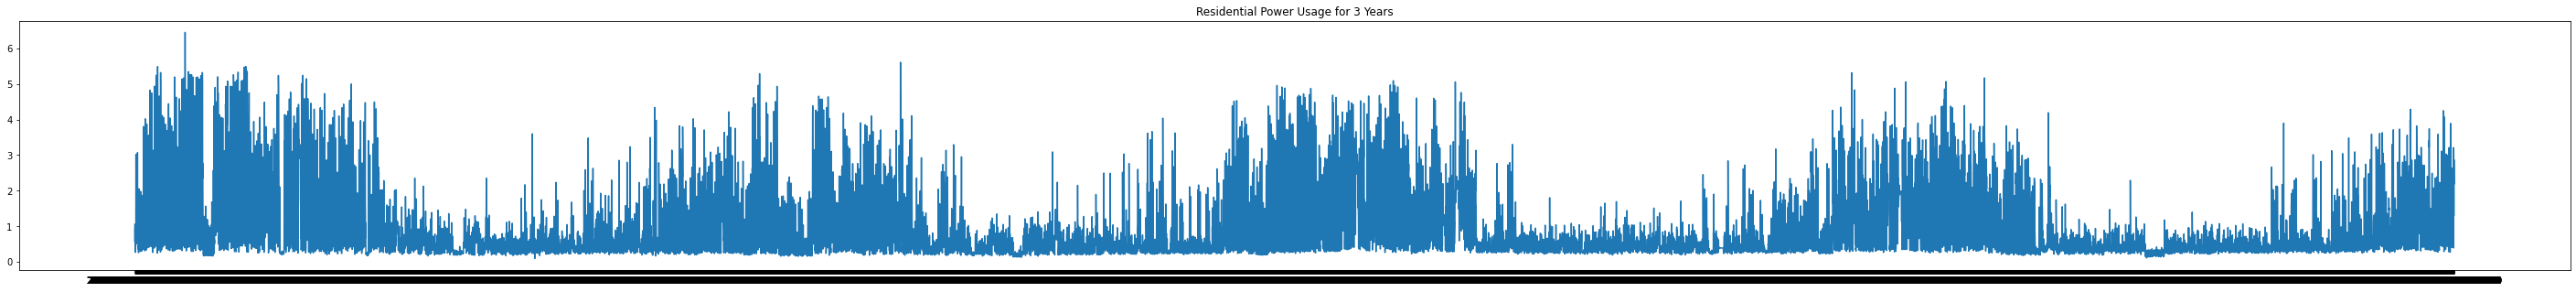

In [ ]:
plt.figure(figsize=(50,5))
plt.plot(dates, value)
plt.title("Residential Power Usage for 3 Years")

In [26]:
class FitCallback(tf.keras.callbacks.Callback):
  def on_train_begin(self, logs=None):
    print("Training has been started!")
  def on_train_end(self, logs=None):
    print("Training has ended!")
  def on_epoch_end(self, batch, logs=None):
    maximum_error = self.maximum_error
    if (logs["mae"] <= maximum_error and logs["val_mae"] <= maximum_error):
      print("\nMae and val_mae has reached below " + str(maximum_error) + ". Good Job!")      


def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  series = tf.expand_dims(series, axis=-1)
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
  ds = ds.flat_map(lambda w: w.batch(window_size + 1))
  ds = ds.shuffle(shuffle_buffer)
  ds = ds.map(lambda w: (w[:-1], w[-1:]))
  return ds.batch(batch_size).prefetch(1)

def get_dense_layer(value):
  return tf.keras.layers.Dense(value, activation="relu")

def get_output_dense_layer():
  return tf.keras.layers.Dense(1)


train_date, test_date, train_value, test_value = train_test_split(dates, value, test_size=0.2)
# 12 hours x 30 days
window_size = 360
train_value = windowed_dataset(train_value, window_size=window_size, batch_size=128, shuffle_buffer=1000)
test_value = windowed_dataset(test_value, window_size=window_size, batch_size=128, shuffle_buffer=1000)

model = tf.keras.models.Sequential([tf.keras.layers.LSTM(window_size, return_sequences=True),
                                    tf.keras.layers.LSTM(window_size),
                                    get_dense_layer(30),
                                    get_dense_layer(10),
                                    get_output_dense_layer()])

optimizer = tf.keras.optimizers.SGD(lr=1.0000e-04, momentum=0.5)

model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

fit_callback = FitCallback()
fit_callback.model = model
fit_callback.maximum_error = scale_data

history = model.fit(train_value,
                    batch_size=128,
                    callbacks=[fit_callback],
                    validation_data=test_value,
                    epochs=11)

Training has been started!
Epoch 1/11

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

110/110 [==============================] - 25s 225ms/step - loss: 0.5225 - mae: 0.9023 - val_loss: 0.5257 - val_mae: 0.8992
Epoch 2/11
110/110 [==============================] - 25s 225ms/step - loss: 0.5057 - mae: 0.8742 - val_loss: 0.5110 - val_mae: 0.8742
Epoch 3/11
110/110 [==============================] - 24s 220ms/step - loss: 0.4831 - mae: 0.8344 - val_loss: 0.4760 - val_mae: 0.8110
Epoch 4/11
110/110 [==============================] - 24s 219ms/step - loss:

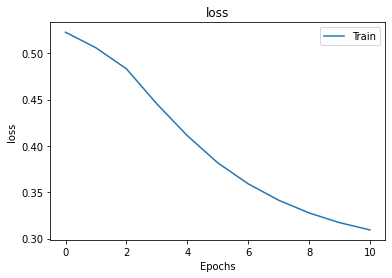

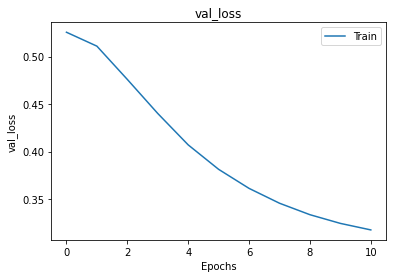

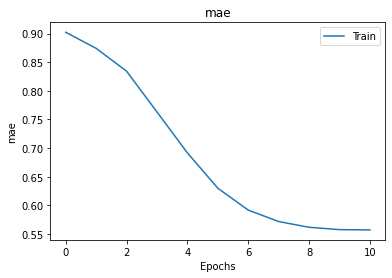

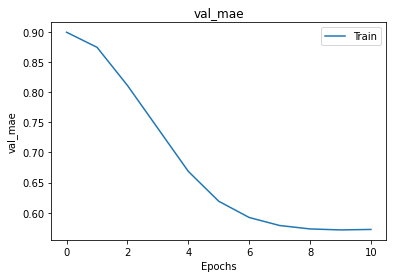

In [27]:
def plot_data(history_keyword):
  plt.plot(history.history[history_keyword])
  plt.title(history_keyword)
  plt.ylabel(history_keyword)
  plt.xlabel("Epochs")
  plt.legend(["Train"], loc="upper right")
  plt.show()

parameters = ["loss", "val_loss", "mae", "val_mae"]
for parameter in parameters:
  plot_data(parameter)